## 1. Load kikuchi Dataset

In [19]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
%matplotlib inline

import numpy as np
import torch
from orix import io
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from data_prepare import filter_files_by_coordinates, KikuchiDataset, coord_xmap_dict
from vae_cnn import VAE, train_vae
from reconstruct_visualization import reconstruct_and_visualize, latent_space_visualize, visualize_latent_maps, get_latent_features

In [3]:
# select the Kikuchi Patterns within ROI
selected_files = filter_files_by_coordinates(
    folder_path="../EBSD_scan",
    x_range=(20,50),
    y_range=(5,35)
)
print(f"{len(selected_files)} Figures are selected within the ROI")

961 Figures are selected within the ROI


In [4]:
dataset = KikuchiDataset(selected_files, transform=None)
print(f"The size of the dataset: {len(dataset)}")

The size of the dataset: 961


In [5]:
coord, image= dataset.__getitem__(1)
print(np.shape(image))

[########################################] | 100% Completed | 106.48 ms
Image data range: -1.0 to 1.0
(1, 120, 120)


In [6]:
# obtain the index information (commercial software processed results)
fname_ang = "../EBSD_scan/Scan3_cropped.ang"
xmap = io.load(fname_ang)   


# construct a dictionary indexed by coordinates to obtain phase_id information (or others/ orientations?)
coord_index= coord_xmap_dict(xmap)

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


## 2. VAE training

In [39]:
# Hyperparameter setting
latent_dim = 2
batch_size = 31
epochs = 10
learning_rate = 1e-4

In [40]:
# device options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
# --- Model instance ---
model = VAE(latent_dim=latent_dim).to(device)
print("--- Model Architecture (LeakyReLU + Tanh Output) ---")
print(model)
print("----------------------------------------------------")

--- Model Architecture (LeakyReLU + Tanh Output) ---
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(9, 9), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(9, 9), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(16, 32, kernel_size=(8, 8), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(9, 9), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(9, 9), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope

In [42]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data preparation
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"Data loaded: {len(dataset)} images, Batch size: {batch_size}")
print("IMPORTANT: Input data assumed to be normalized to [-1, 1] for Tanh output.")

Data loaded: 961 images, Batch size: 31
IMPORTANT: Input data assumed to be normalized to [-1, 1] for Tanh output.


In [43]:
# VAE model training
train_vae(dataloader, model, device, optimizer, epochs)

Epoch [1/10], Batch [1/31], Loss: 1138.2731, MSE: 1138.2591, KLD: 0.0140
Epoch [1/10], Batch [31/31], Loss: 1163.4417, MSE: 1163.4146, KLD: 0.0270
====> Epoch: 1 Average loss: 1196.9394 (MSE: 1196.9215, KLD: 0.0179)
Epoch [2/10], Batch [1/31], Loss: 1117.7084, MSE: 1117.6801, KLD: 0.0284
Epoch [2/10], Batch [31/31], Loss: 1001.1741, MSE: 1000.7176, KLD: 0.4566
====> Epoch: 2 Average loss: 1073.1860 (MSE: 1072.9904, KLD: 0.1956)
Epoch [3/10], Batch [1/31], Loss: 1021.3850, MSE: 1020.7126, KLD: 0.6724
Epoch [3/10], Batch [31/31], Loss: 928.9585, MSE: 920.6598, KLD: 8.2986
====> Epoch: 3 Average loss: 972.8540 (MSE: 969.5532, KLD: 3.3008)
Epoch [4/10], Batch [1/31], Loss: 914.6991, MSE: 903.9127, KLD: 10.7864
Epoch [4/10], Batch [31/31], Loss: 884.0884, MSE: 871.6258, KLD: 12.4626
====> Epoch: 4 Average loss: 895.6494 (MSE: 884.4721, KLD: 11.1772)
Epoch [5/10], Batch [1/31], Loss: 854.5100, MSE: 844.3735, KLD: 10.1365
Epoch [5/10], Batch [31/31], Loss: 802.5764, MSE: 788.9480, KLD: 13.628

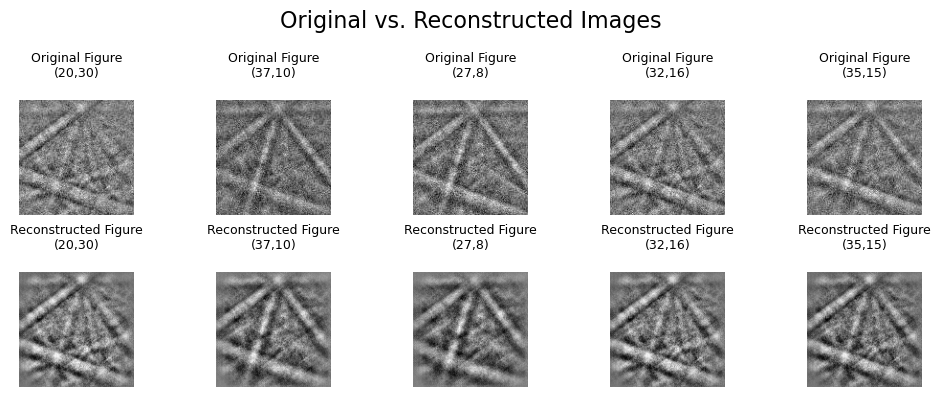

In [12]:
# kikuchi Pattern reconstruction and display part of them
reconstruct_and_visualize(model, device, dataloader, 5)

In [44]:
# obtain the corresponding phase id of each kikuchi pattern
phase_dict = coord_xmap_dict(xmap, 0.05)

In [45]:
latents, all_labels, all_x_indices, all_y_indices =get_latent_features(model, dataloader, device, phase_dict, 961)

Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 2



--- Visualizing Latent Space (using t-SNE) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 2
Applying t-SNE... (This might take a while for many points)


c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished. Reduced shape: (961, 2)


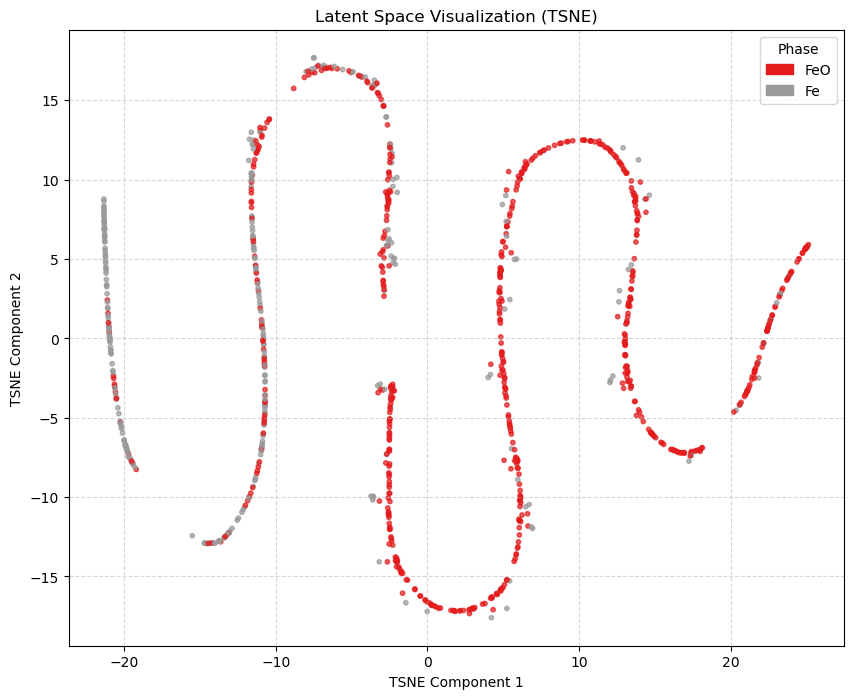

In [47]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using t-SNE) ---")
latent_space_visualize(model, dataloader, device, phase_dict, method='tsne', max_points=961) # Increase batches for better viz


--- Visualizing Latent Space (using PCA) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 2
PCA finished. Reduced shape: (961, 2)


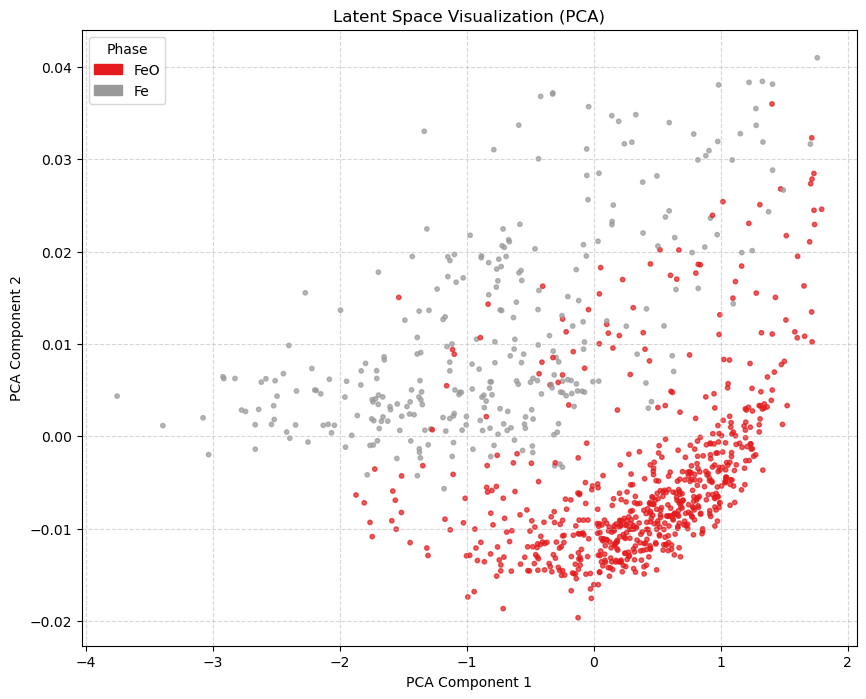

In [48]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using PCA) ---")
latent_space_visualize(model, dataloader, device,phase_dict, method='pca', max_points=961) # Increase batches for better viz


--- Visualizing Latent Space (using cNMF) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 2


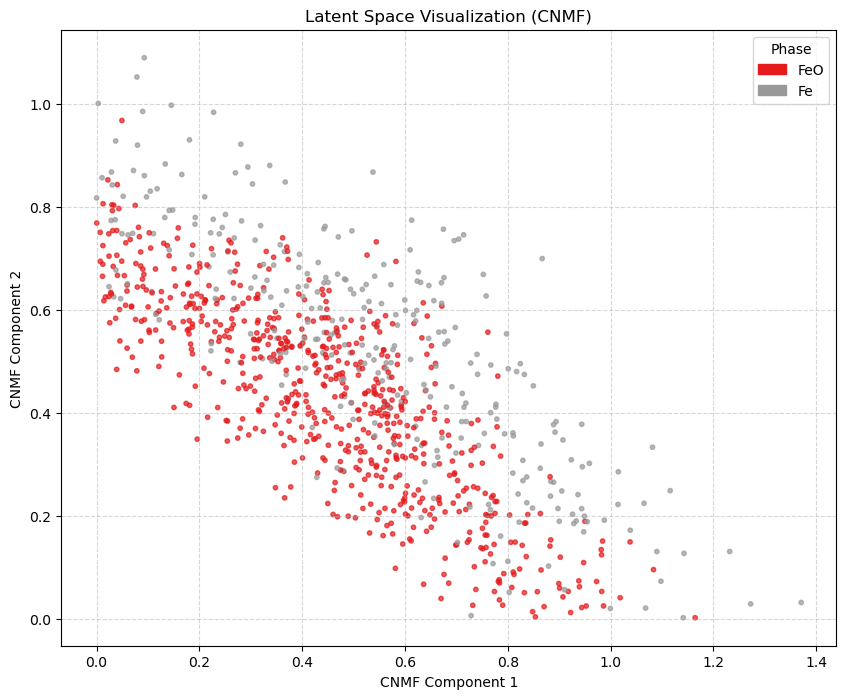

In [49]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using cNMF) ---")
latent_space_visualize(model, dataloader, device, phase_dict, method='cnmf', max_points=961, components_coords=[(40, 27), (44, 12)]) # Increase batches for better viz

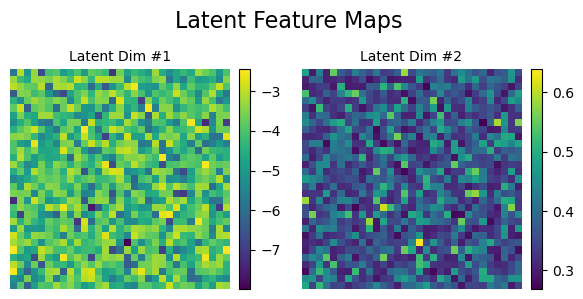

In [46]:
fig, axes = visualize_latent_maps(latents, latent_dim, highlight_idx =None, save_idx= None, save_dir= 'maps', save_prefix='dim')

(-0.5, 30.5, 30.5, -0.5)

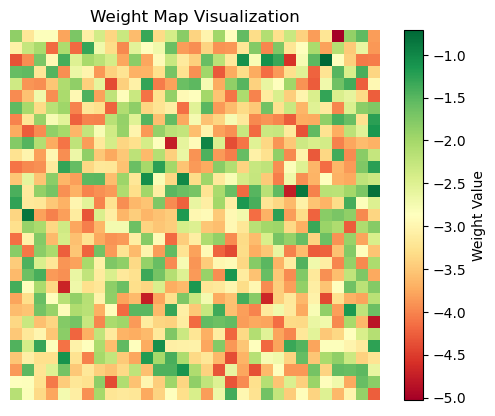

In [18]:
import matplotlib.pyplot as plt
feature_maps = latents.T.reshape(latent_dim, 31, 31)
im= plt.imshow(feature_maps[0], cmap="RdYlGn")
plt.colorbar(im, label='Weight Value') 
plt.title("Weight Map Visualization")
plt.axis('off')